# **CSE655 Homework 3**

* **GTU Artificial Intelligence MSc.**
* **Student Name:** Berkin Barış Yılmaz
* **ID:** 244201001109

## **Part 1: Prediction with LSTM**

In [107]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [381]:
# Extract the data
tsla_dates = []
tsla_close = []
tsla_volume = []

with open("TSLA.csv", "r") as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        tsla_dates.append(row[0])
        tsla_close.append(float(row[4]))
        tsla_volume.append(float(row[6]))

In [493]:
class Data1D:
    def __init__(self, name:str, data:list):
        self.name = name
        self.data = data
        self.max_x = max(data)
        self.min_x = min(data)

    def normalized(self)->list:
        return [(x - self.min_x) / (self.max_x - self.min_x) for x in self.data]

    def denormalize(self, new:list)->list:
        return [x * (self.max_x - self.min_x) + self.min_x for x in new]


In [383]:
tsla = {
    "Close"  : Data1D("Close", tsla_close),
    "Volume" : Data1D("Volume", tsla_volume)
}

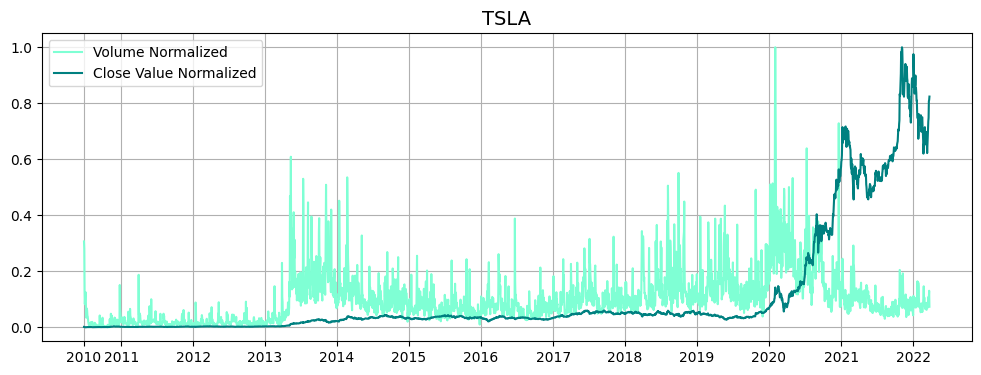

In [384]:
years = [date[:4] for date in tsla_dates] 
unique_years = sorted(set(years))
xticks_positions = [years.index(year) for year in unique_years]

plt.figure(figsize=(12, 4))
plt.plot(tsla["Volume"].normalized(), label="Volume Normalized", color="aquamarine")
plt.plot(tsla["Close"].normalized(), label="Close Value Normalized", color="teal")

plt.title("TSLA", fontsize=14)

plt.xticks(xticks_positions, unique_years)
plt.legend()
plt.grid(True)
plt.show()

In [385]:
def sequencer(data, interval=10):
    """
    Creates windowed data pieces for training and validation.
    X (Input)  = [i, i+1, i+2 ... interval - 1] 
    Y (Output) = [interval]

    @param data: Time sequenced data set
    @param interval: Window size  
    @return: np.array X, Y 
    """
    X, Y = [], []
    for i in range(len(data) - interval):
        X.append(data[i:i + interval])
        Y.append(data[i + interval])
    return np.array(X), np.array(Y)

In [386]:
interval = 10
data = np.array(tsla["Close"].normalized()).T

X, Y = sequencer(data, interval)

# Training & Validation sets (%70 train, %30 validation)
split_index = int(0.7 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
Y_train, Y_val = Y[:split_index], Y[split_index:]

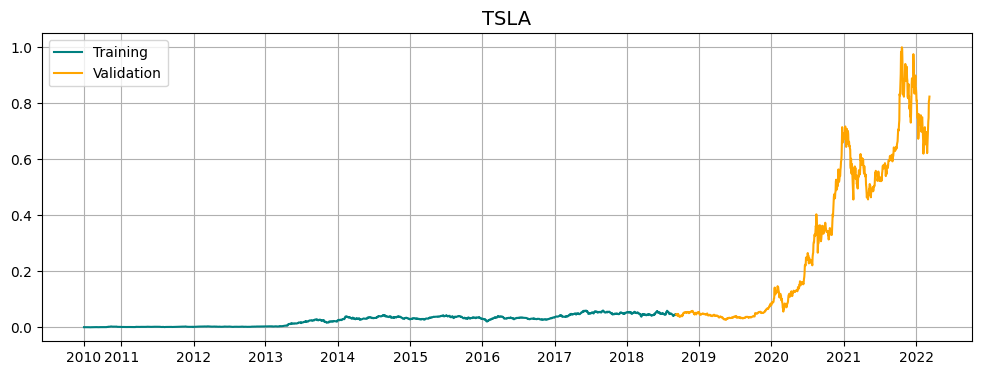

In [387]:
plt.figure(figsize=(12, 4))
plt.plot(range(len(Y_train)), Y_train, label="Training", color="teal")
plt.plot(range(len(Y_train), len(Y_train) + len(Y_val)), Y_val, label="Validation", color="orange")

plt.title("TSLA", fontsize=14)

plt.xticks(xticks_positions, unique_years)
plt.legend()
plt.grid(True)
plt.show()

In [388]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1], 1)),
    layers.LSTM(16),
    layers.Dense(1)
])

In [389]:
# Compile
model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate = 0.001))

# Model Train
history = model.fit(
    X_train, Y_train, 
    validation_data=(X_val, Y_val), 
    epochs=10, 
    batch_size=1,
)


Epoch 1/10
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.3528e-04 - val_loss: 0.0015
Epoch 2/10
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.8050e-06 - val_loss: 0.0017
Epoch 3/10
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.9360e-06 - val_loss: 0.0016
Epoch 4/10
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.4590e-06 - val_loss: 0.0012
Epoch 5/10
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.7780e-06 - val_loss: 0.0021
Epoch 6/10
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.2414e-06 - val_loss: 0.0014
Epoch 7/10
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.5583e-06 - val_loss: 0.0013
Epoch 8/10
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.1308e-06 - val_loss: 0.0016
Epoch 9/10
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.7945e-06 - val_loss: 7.9278e-04
Epoch 10/10
2062/2062 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.8668e-06 - val_loss: 0.0010


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


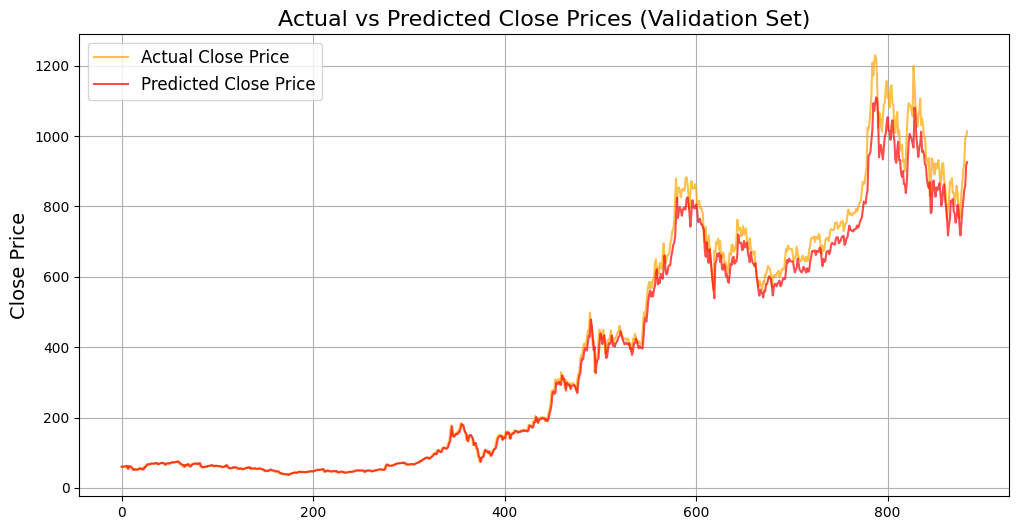

In [390]:
# Predict
predictions = model.predict(X_val)

# Denormalized predictions
denormalized_predictions = Data1D("Close", tsla_close).denormalize(predictions.flatten())
denormalized_actual = Data1D("Close", tsla_close).denormalize(Y_val)

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the denormalized predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(denormalized_actual, label="Actual Close Price", color='orange', alpha=0.7)
plt.plot(denormalized_predictions, label="Predicted Close Price", color='red', alpha=0.7)
plt.title("Actual vs Predicted Close Prices (Validation Set)", fontsize=16)
plt.ylabel("Close Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


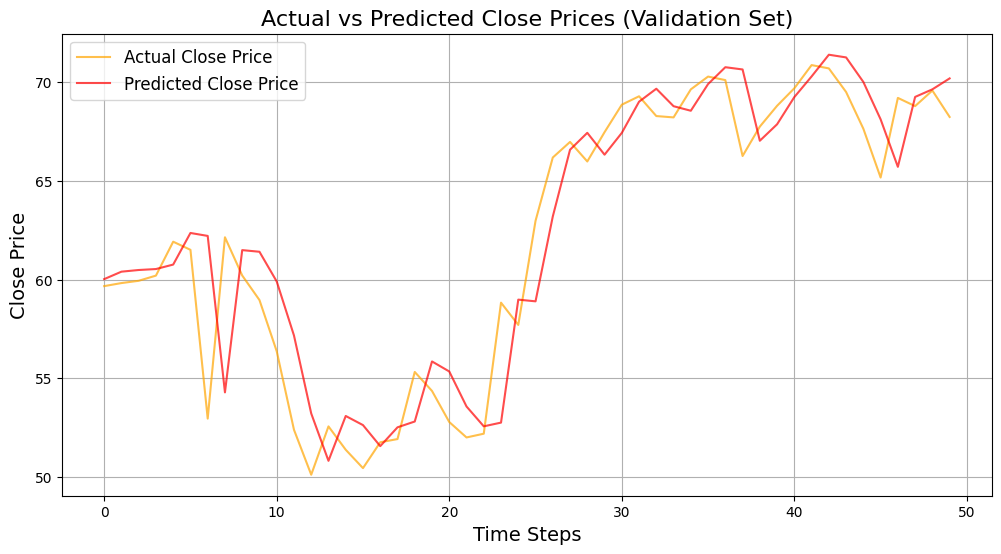

In [391]:
# Plot the denormalized predictions vs actual values for first 100 days
actual_price = denormalized_actual[:100]
predicted_price = denormalized_predictions[:100]

plt.figure(figsize=(12, 6))
plt.plot(actual_price[:50], label="Actual Close Price", color='orange', alpha=0.7)
plt.plot(predicted_price[:50], label="Predicted Close Price", color='red', alpha=0.7)
plt.title("Actual vs Predicted Close Prices (Validation Set)", fontsize=16)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

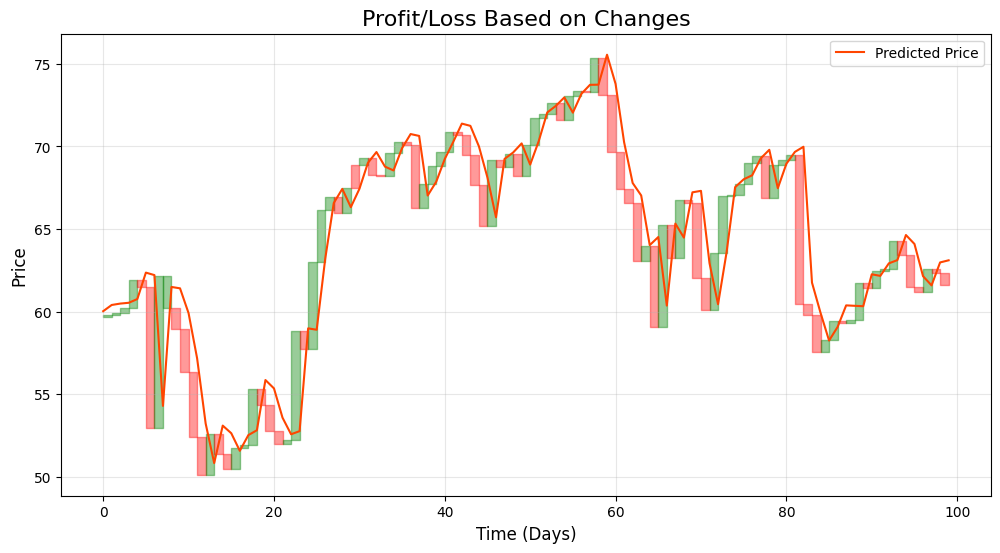

In [392]:

actual_change = np.diff(actual_price)
predicted_change = [predicted_price[i] - actual_price[i - 1] for i in range(1, len(predicted_price))]

plt.figure(figsize=(12, 6))

for i in range(len(actual_change)):
    color = 'green' if np.sign(actual_change[i]) == np.sign(predicted_change[i]) else 'red'
    plt.fill_between([i, i + 1], actual_price[i], actual_price[i + 1], color=color, alpha=0.4)

plt.plot(predicted_price, label="Predicted Price", color="orangered")

plt.title("Profit/Loss Based on Changes", fontsize=16)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

plt.show()

## **Part 1.2 Adding The Gold Prices**

* GOLD.csv Reference : kaggle.com/datasets/sid321axn/gold-price-prediction-dataset

In [416]:
# Extract the data
gold_dates = []
gold_close = []

with open("GOLD.csv", "r") as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        gold_dates.append(row[0])
        gold_close.append(float(row[4]))

print("TSLA", tsla_dates[0], tsla_dates[-1], max(tsla_close))
print("GOLD", gold_dates[0], gold_dates[-1], max(gold_close))

TSLA 2010-06-29 2022-03-24 1229.910034
GOLD 2011-12-15 2018-12-31 173.610001


In [394]:
# Removing the TSLA and GOLD  data if the time is not same 

i = 0
while 1:
    if (i >= len(tsla_dates)): break
    if not gold_dates.__contains__(tsla_dates[i]): 
        tsla_dates.pop(i)
        tsla_close.pop(i) 
        continue
    i += 1

i = 0
while 1:
    if (i >= len(gold_dates)): break
    if not tsla_dates.__contains__(gold_dates[i]): 
        gold_dates.pop(i)
        gold_close.pop(i)
        continue 
    i += 1


print(len(tsla_close), len(gold_close))
print(len(tsla_dates), len(gold_dates))

print("TSLA", tsla_dates[0], tsla_dates[-1], max(tsla_close))
print("GOLD", gold_dates[0], gold_dates[-1], max(gold_close))



1718 1718
1718 1718
TSLA 2011-12-15 2018-12-31 77.0
GOLD 2011-12-15 2018-12-31 173.610001


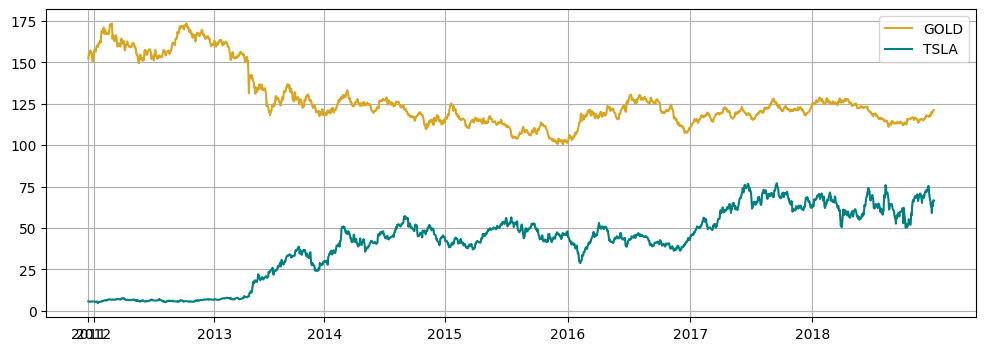

In [395]:
years = [date[:4] for date in gold_dates] 
unique_years = sorted(set(years))
xticks_positions = [years.index(year) for year in unique_years]

plt.figure(figsize=(12, 4))
plt.plot(gold_close, label="GOLD", color="goldenrod")
plt.plot(tsla_close, label="TSLA", color="teal")

plt.xticks(xticks_positions, unique_years)
plt.legend()
plt.grid(True)
plt.show()

In [610]:
tsla = Data1D(name="TSLA", data=tsla_close)
gold = Data1D(name="GOLD", data=gold_close)

# Apply same normalization minmax values
tsla.max_x = max(max(gold_close) , max(tsla_close))
gold.max_x = max(max(gold_close) , max(tsla_close))
tsla.min_x = min(min(gold_close) , min(tsla_close))
gold.min_x = min(min(gold_close) , min(tsla_close))

In [611]:
interval = 10
data = np.array([tsla.normalized(), gold.normalized()]).T

X, Y = sequencer(data, interval)

Y = Y.T[0] # sequencer function crops gold values to Y output too. Only TSLA values will be predicted 

# Training & Validation sets (%70 train, %30 validation)
split_index = int(0.7 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
Y_train, Y_val = Y[:split_index], Y[split_index:]

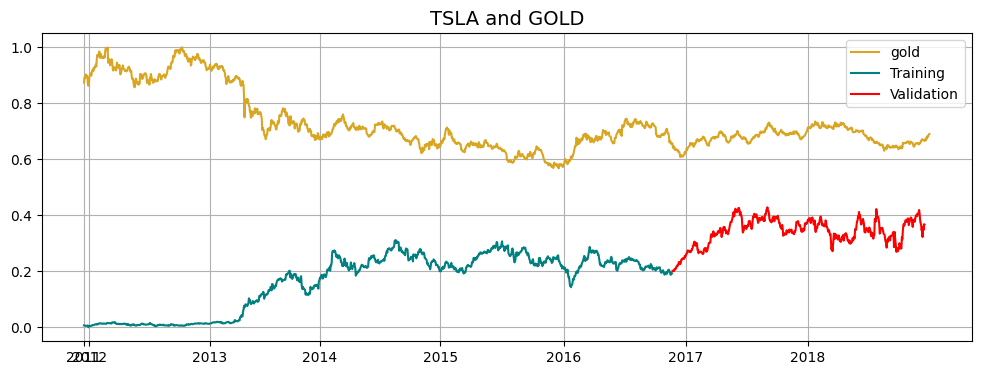

In [612]:
plt.figure(figsize=(12, 4))
plt.plot(gold.normalized(), label="gold", color="goldenrod")
plt.plot(range(len(Y_train)), Y_train, label="Training", color="teal")
plt.plot(range(len(Y_train), len(Y_train) + len(Y_val)), Y_val, label="Validation", color="red")

plt.title("TSLA and GOLD", fontsize=14)

plt.xticks(xticks_positions, unique_years)
plt.legend()
plt.grid(True)
plt.show()

In [613]:
print(X_train.shape)
print(Y_train.shape)

(1195, 10, 2)
(1195,)


In [614]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.LSTM(16),
    layers.Dense(1)
])

In [615]:
# Compile
model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate = 0.001))

# Model Train
history = model.fit(
    X_train, Y_train, 
    validation_data=(X_val, Y_val), 
    epochs=25, 
    batch_size=4,
)

Epoch 1/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0073 - val_loss: 3.7462e-04
Epoch 2/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3280e-04 - val_loss: 3.4697e-04
Epoch 3/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3821e-04 - val_loss: 3.8700e-04
Epoch 4/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2286e-04 - val_loss: 3.1880e-04
Epoch 5/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5712e-04 - val_loss: 3.6219e-04
Epoch 6/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0509e-04 - val_loss: 3.4763e-04
Epoch 7/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2752e-04 - val_loss: 3.0961e-04
Epoch 8/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1308e-04 - val_loss: 2.8077e-04
Epoch 9/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.8478e-05 - val_loss: 2.7145e-04
Epoch 10/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.3963e-05 - val_loss: 2.8791e-04
Epoch 11/25
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


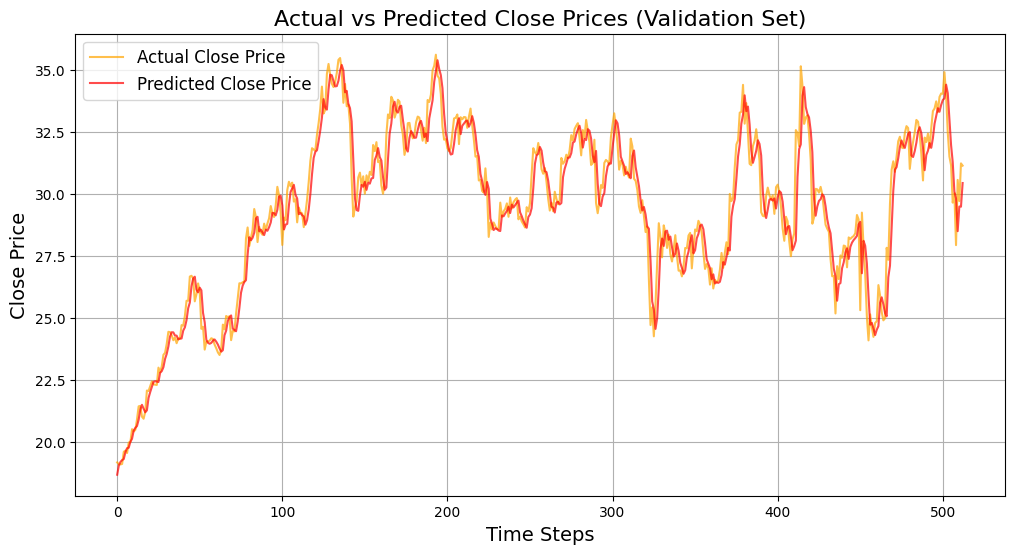

In [616]:
# Predict
predictions = model.predict(X_val)

# Denormalized predictions
denormalized_predictions = Data1D("Close", tsla_close).denormalize(predictions.flatten())
denormalized_actual = Data1D("Close", tsla_close).denormalize(Y_val)

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the denormalized predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(denormalized_actual, label="Actual Close Price", color='orange', alpha=0.7)
plt.plot(denormalized_predictions, label="Predicted Close Price", color='red', alpha=0.7)
plt.title("Actual vs Predicted Close Prices (Validation Set)", fontsize=16)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


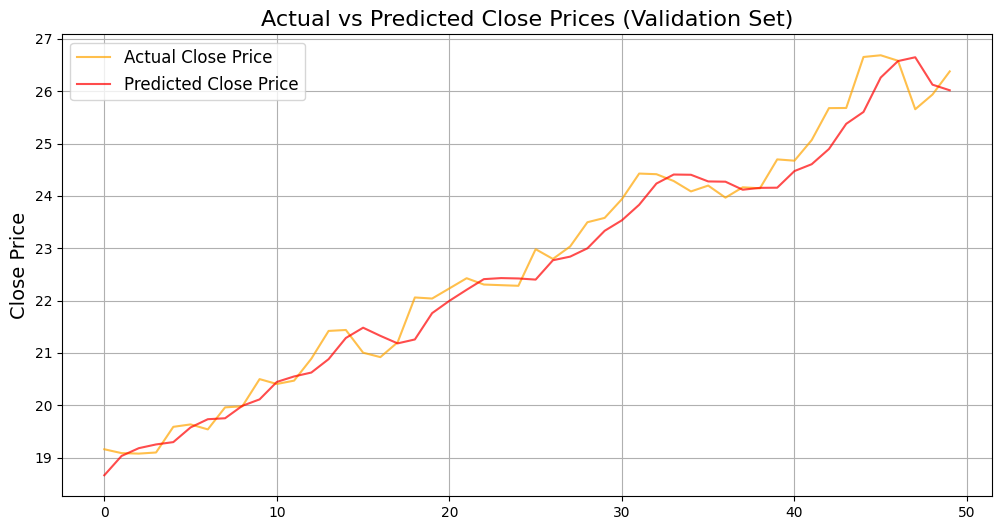

In [617]:
# Plot the denormalized predictions vs actual values for first 100 days
actual_price = denormalized_actual[:100]
predicted_price = denormalized_predictions[:100]

plt.figure(figsize=(12, 6))
plt.plot(actual_price[:50], label="Actual Close Price", color='orange', alpha=0.7)
plt.plot(predicted_price[:50], label="Predicted Close Price", color='red', alpha=0.7)
plt.title("Actual vs Predicted Close Prices (Validation Set)", fontsize=16)
plt.ylabel("Close Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

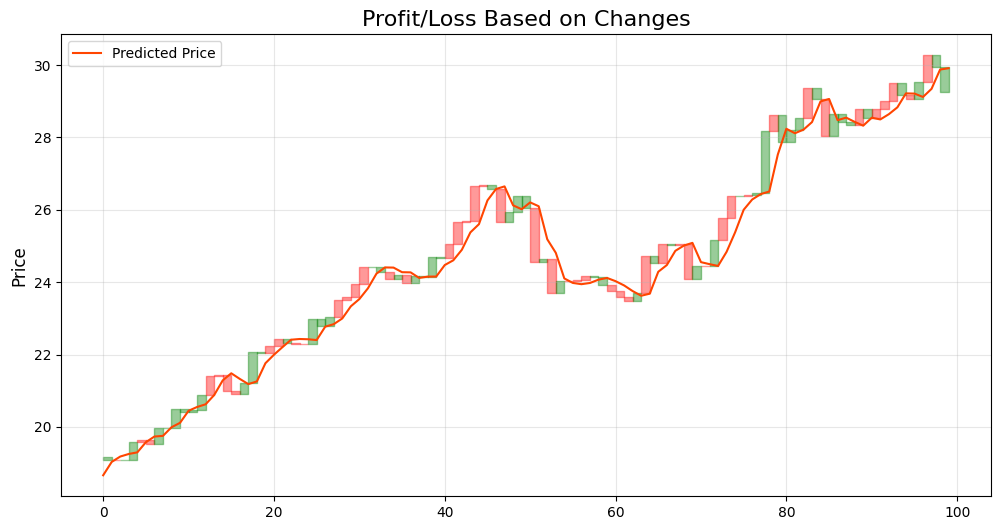

In [618]:
actual_change = np.diff(actual_price)
predicted_change = [predicted_price[i] - actual_price[i - 1] for i in range(1, len(predicted_price))]

plt.figure(figsize=(12, 6))

for i in range(len(actual_change)):
    color = 'green' if np.sign(actual_change[i]) == np.sign(predicted_change[i]) else 'red'
    plt.fill_between([i, i + 1], actual_price[i], actual_price[i + 1], color=color, alpha=0.4)

plt.plot(predicted_price, label="Predicted Price", color="orangered")

plt.title("Profit/Loss Based on Changes", fontsize=16)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

plt.show()

## **Part 1 Conclusion**

The purpose of an LSTM model for stock prediction is to forecast the stock price for the next day as accurately as possible, allowing the user to make investments based on the model’s suggestions with the aim of generating profit. Setting aside the economic irrationalities of this seemingly "money trick" approach, when we analyze it from a data science perspective, we can acknowledge that sequential data often contains patterns that can be predicted.

Examining the results of the trained models, we observe a tendency for the model to replicate the previous day's stock price. In the LSTM model I implemented without incorporating gold data, TSLA’s value has significantly increased over the last three years, reaching levels not seen in the training dataset. This highlights a drop in model performance as the stock prices deviate further from the min-max range of the training dataset. When gold data (available until 2018) is included in the training process, we observe that the stock values for recent years align more closely with the training dataset’s min-max range. Moreover, incorporating gold data improves the alignment between the model's predictions and the actual values.

However, upon closer examination of the outputs, the model still exhibits a tendency to replicate the previous day's stock value. Introducing a confidence score alongside the predicted value and adjusting the loss function accordingly could potentially balance the profit margin resulting from the predictions. Additionally, I suspect that normalizing stock values might lead to the disappearance of smaller data variations. For this reason, using changes in stock prices over the last 'n' days, instead of the absolute values for the last 'n' days, could be a more effective input for the model.

In conclusion, as demonstrated by the Profit/Loss graph, this model fails to consistently generate stable profits for the user.

## **Part 2: Prediction with Transformers**

In [619]:
# Extract the data
tsla_dates = []
tsla_close = []
tsla_volume = []

with open("TSLA.csv", "r") as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        tsla_dates.append(row[0])
        tsla_close.append(float(row[4]))
        tsla_volume.append(float(row[6]))

In [541]:
tsla = {
    "Close"  : Data1D("Close", tsla_close),
    "Volume" : Data1D("Volume", tsla_volume)
}

In [542]:
interval = 20
data = np.array(tsla["Close"].normalized()).T

X, Y = sequencer(data, interval)

# Training & Validation sets (%70 train, %30 validation)
split_index = int(0.7 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
Y_train, Y_val = Y[:split_index], Y[split_index:]

# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

print("X_train", X_train.shape, tsla["Close"].denormalize(X_train[0]))
print("Y_train", Y_train.shape, tsla["Close"].denormalize([Y_train[0]]))


X_train (2055, 20, 1) [array([4.778]), array([4.766]), array([4.392]), array([3.84]), array([3.222]), array([3.16]), array([3.492]), array([3.48]), array([3.41]), array([3.628]), array([3.968]), array([3.978]), array([4.128]), array([4.382]), array([4.06]), array([4.044]), array([4.2]), array([4.258]), array([4.19]), array([4.11])]
Y_train (2055,) [4.144]


In [549]:
# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Embedding
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Attention
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x) 
    res = x + inputs

    # Feed Forward
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)

    return x + res # Result

# Transformer Model
def build_transformer_model(input_shape, head_size=64, num_heads=8, ff_dim=32, num_transformer_blocks=1, dropout=0.01):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    # Stack Transformer Blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    # Fully Connected Layers
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="linear")(x)
    
    # Compile Model
    model = models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse")
    return model

# Dataset Information
input_shape = (X_train.shape[1], X_train.shape[2])

# Create Model
model = build_transformer_model(input_shape=input_shape)

# Model Summary
model.summary()


Model: "functional_92"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_107     │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ input_layer_107[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_463         │ (None, 20, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_278 (Add)       │ (None, 20, 1)     │          0 │ dropout_463[0][0… │
│                     │                   │            │ input_layer_107[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ add_278[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_410 (Dense)   │ (None, 20, 32)    │         64 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_464         │ (None, 20, 32)    │          0 │ dense_410[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_411 (Dense)   │ (None, 20, 1)     │         33 │ dropout_464[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_279 (Add)       │ (None, 20, 1)     │          0 │ dense_411[0][0],  │
│                     │                   │            │ add_278[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 20)        │          0 │ add_279[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_465         │ (None, 20)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_412 (Dense)   │ (None, 32)        │        672 │ dropout_465[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_413 (Dense)   │ (None, 1)         │         33 │ dense_412[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,391 (17.15 KB)

 Trainable params: 4,391 (17.15 KB)

 Non-trainable params: 0 (0.00 B)

In [552]:
# Model Train
history = model.fit(
    X_train, Y_train, 
    validation_data = (X_val, Y_val), 
    epochs = 10, 
    batch_size = 8,
)

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.8204e-06 - val_loss: 0.0017
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0810e-06 - val_loss: 9.5084e-04
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5023e-06 - val_loss: 9.3612e-04
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.6553e-06 - val_loss: 8.4573e-04
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.9102e-06 - val_loss: 0.0011
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0656e-06 - val_loss: 7.6442e-04
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6482e-06 - val_loss: 7.7780e-04
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.9897e-06 - val_loss: 9.5729e-04
Epoch 9/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4053e-06 - val_loss: 7.7229e-04
Epoch 10/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1919e-06 - val_loss: 0.0014


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[0.04279923]


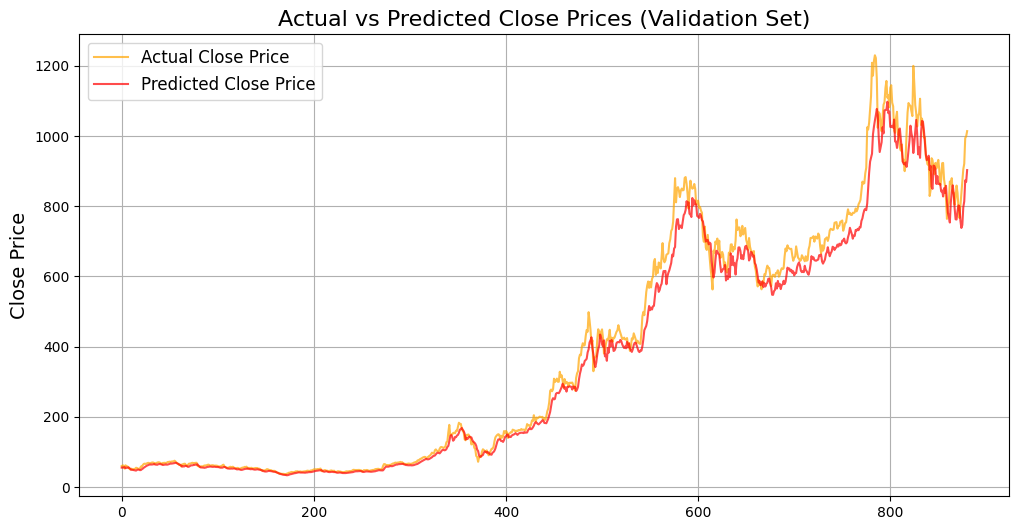

In [553]:
# Predict
predictions = model.predict(X_val)
print(predictions[0])
# Denormalized predictions
denormalized_predictions = Data1D("Close", tsla_close).denormalize(predictions.flatten())
denormalized_actual = Data1D("Close", tsla_close).denormalize(Y_val)

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the denormalized predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(denormalized_actual, label="Actual Close Price", color='orange', alpha=0.7)
plt.plot(denormalized_predictions, label="Predicted Close Price", color='red', alpha=0.7)
plt.title("Actual vs Predicted Close Prices (Validation Set)", fontsize=16)
plt.ylabel("Close Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


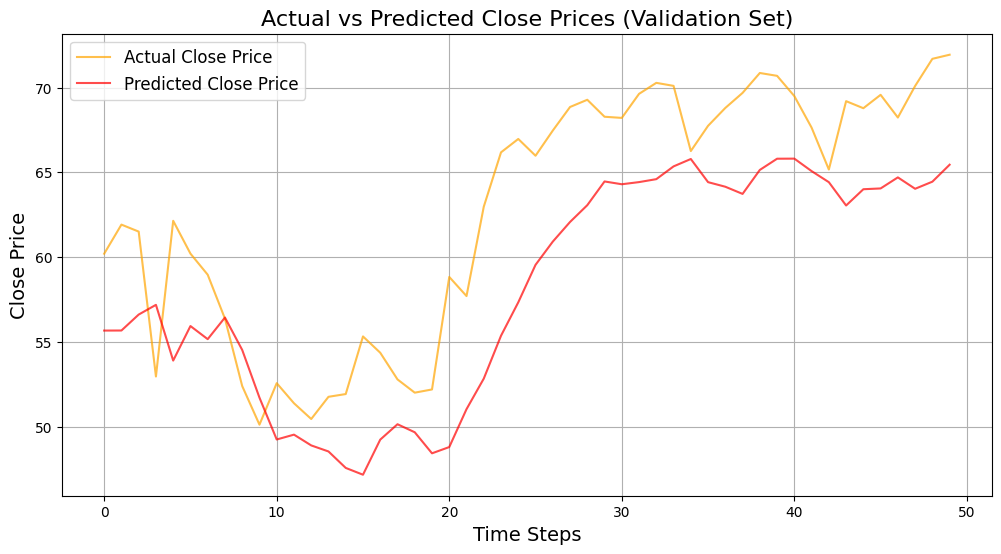

In [554]:
# Plot the denormalized predictions vs actual values for first 100 days
actual_price = denormalized_actual[:100]
predicted_price = denormalized_predictions[:100]

plt.figure(figsize=(12, 6))
plt.plot(actual_price[:50], label="Actual Close Price", color='orange', alpha=0.7)
plt.plot(predicted_price[:50], label="Predicted Close Price", color='red', alpha=0.7)
plt.title("Actual vs Predicted Close Prices (Validation Set)", fontsize=16)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

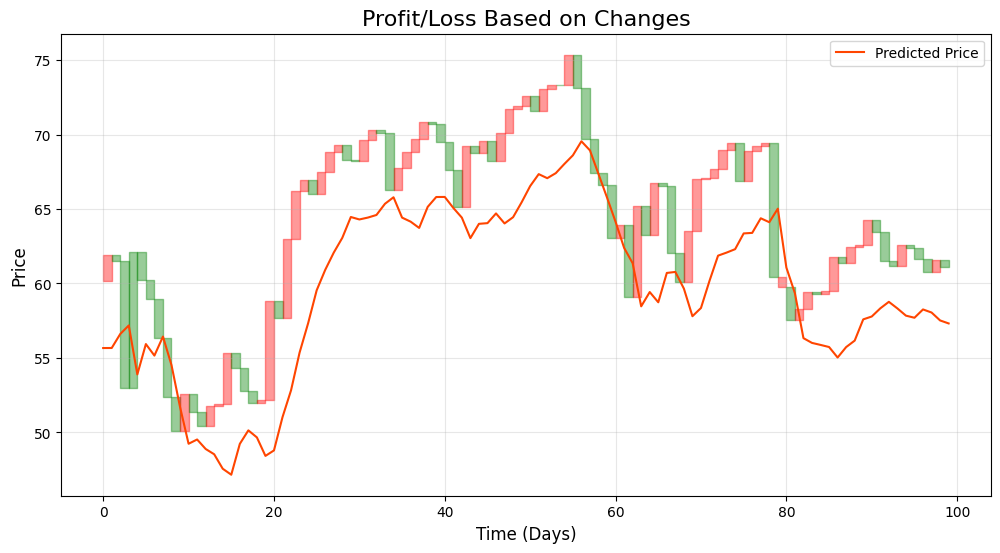

In [555]:
actual_change = np.diff(actual_price)
predicted_change = [predicted_price[i] - actual_price[i - 1] for i in range(1, len(predicted_price))]

plt.figure(figsize=(12, 6))

for i in range(len(actual_change)):
    color = 'green' if np.sign(actual_change[i]) == np.sign(predicted_change[i]) else 'red'
    plt.fill_between([i, i + 1], actual_price[i], actual_price[i + 1], color=color, alpha=0.4)

plt.plot(predicted_price, label="Predicted Price", color="orangered")

plt.title("Profit/Loss Based on Changes", fontsize=16)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

plt.show()

In [667]:
# Extract the data
gold_dates = []
gold_close = []

tsla_dates = []
tsla_close = []

with open("TSLA.csv", "r") as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        tsla_dates.append(row[0])
        tsla_close.append(float(row[4]))

with open("GOLD.csv", "r") as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        gold_dates.append(row[0])
        gold_close.append(float(row[4]))

print("TSLA", tsla_dates[0], tsla_dates[-1], max(tsla_close))
print("GOLD", gold_dates[0], gold_dates[-1], max(gold_close))

TSLA 2010-06-29 2022-03-24 1229.910034
GOLD 2011-12-15 2018-12-31 173.610001


In [668]:
# Removing the TSLA and GOLD  data if the time is not same 
i = 0
while 1:
    if (i >= len(tsla_dates)): break
    if not gold_dates.__contains__(tsla_dates[i]): 
        tsla_dates.pop(i)
        tsla_close.pop(i) 
        continue
    i += 1

i = 0
while 1:
    if (i >= len(gold_dates)): break
    if not tsla_dates.__contains__(gold_dates[i]): 
        gold_dates.pop(i)
        gold_close.pop(i)
        continue 
    i += 1


print(len(tsla_close), len(gold_close))
print(len(tsla_dates), len(gold_dates))

print("TSLA", tsla_dates[0], tsla_dates[-1], max(tsla_close))
print("GOLD", gold_dates[0], gold_dates[-1], max(gold_close))



1718 1718
1718 1718
TSLA 2011-12-15 2018-12-31 77.0
GOLD 2011-12-15 2018-12-31 173.610001


In [669]:
tsla = Data1D(name="TSLA", data=tsla_close)
gold = Data1D(name="GOLD", data=gold_close)

# Apply same normalization minmax values
tsla.max_x = max(max(gold_close) , max(tsla_close))
gold.max_x = max(max(gold_close) , max(tsla_close))
tsla.min_x = min(min(gold_close) , min(tsla_close))
gold.min_x = min(min(gold_close) , min(tsla_close))

In [670]:
interval = 10
data = np.array([tsla.normalized(), gold.normalized()]).T

X, Y = sequencer(data, interval)

Y = Y.T[0] # sequencer function crops gold values to Y output too. Only TSLA values will be predicted 

# Training & Validation sets (%70 train, %30 validation)
split_index = int(0.7 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
Y_train, Y_val = Y[:split_index], Y[split_index:]

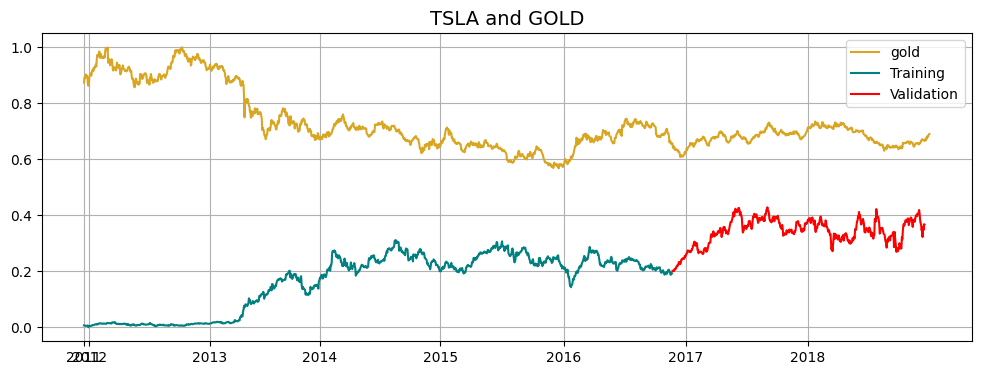

In [672]:
plt.figure(figsize=(12, 4))
plt.plot(gold.normalized(), label="gold", color="goldenrod")
plt.plot(range(len(Y_train)), Y_train, label="Training", color="teal")
plt.plot(range(len(Y_train), len(Y_train) + len(Y_val)), Y_val, label="Validation", color="red")

plt.title("TSLA and GOLD", fontsize=14)

plt.xticks(xticks_positions, unique_years)
plt.legend()
plt.grid(True)
plt.show()

In [673]:
print(X_train.shape)
print(Y_train.shape)

print(X_train[0])
print(Y_train[0])


(1195, 10, 2)
(1195,)
[[0.00689729 0.87412158]
 [0.00616378 0.89127603]
 [0.00586802 0.8891465 ]
 [0.00604548 0.90162787]
 [0.00565506 0.90269268]
 [0.00589168 0.89606744]
 [0.00604548 0.89766461]
 [0.00683813 0.88938317]
 [0.00676715 0.86643162]
 [0.00702742 0.86235002]]
0.006826301925879007


In [677]:
# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Embedding
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    # Attention
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x) 
    res = x + inputs  # Residual connection

    # Feed Forward
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)  # Ensure the output matches input shape for residual connection

    return x + res  # Result

# Transformer Model
def build_transformer_model(input_shape, head_size=128, num_heads=4, ff_dim=16, num_transformer_blocks=1, dropout=0.05):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    # Stack Transformer Blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # Global Average Pooling
    x = layers.Flatten()(x)  # Using default "channels_last"
    
    # Fully Connected Layers
    # x = layers.Dropout(dropout)(x)
    # x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="relu")(x)  # Regression output
    
    # Compile Model
    model = models.Model(inputs, outputs)
    model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate = 0.001))

    return model

# Dataset Information
input_shape = (X_train.shape[1], X_train.shape[2])  # (20, 2) -> 20 timesteps, 2 features

# Create Model
model = build_transformer_model(input_shape=input_shape)

# Model Summary
model.summary()


Model: "functional_126"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_143     │ (None, 10, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ input_layer_143[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 2)     │      5,634 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_579         │ (None, 10, 2)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_345 (Add)       │ (None, 10, 2)     │          0 │ dropout_579[0][0… │
│                     │                   │            │ input_layer_143[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ add_345[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_528 (Dense)   │ (None, 10, 16)    │         48 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_580         │ (None, 10, 16)    │          0 │ dense_528[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_529 (Dense)   │ (None, 10, 2)     │         34 │ dropout_580[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_346 (Add)       │ (None, 10, 2)     │          0 │ dense_529[0][0],  │
│                     │                   │            │ add_345[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 20)        │          0 │ add_346[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_530 (Dense)   │ (None, 1)         │         21 │ flatten_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,745 (22.44 KB)

 Trainable params: 5,745 (22.44 KB)

 Non-trainable params: 0 (0.00 B)

In [680]:
# Model Train
history = model.fit(
    X_train, Y_train, 
    validation_data=(X_val, Y_val), 
    epochs=25, 
    batch_size=16,
    verbose=1
)

Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4467e-04 - val_loss: 5.1456e-04
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6333e-04 - val_loss: 3.8847e-04
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6901e-04 - val_loss: 2.2813e-04
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4916e-04 - val_loss: 2.5335e-04
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3315e-04 - val_loss: 4.4974e-04
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5088e-04 - val_loss: 2.0039e-04
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6061e-04 - val_loss: 5.6331e-04
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6148e-04 - val_loss: 2.5895e-04
Epoch 9/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2957e-04 - val_loss: 3.4355e-04
Epoch 10/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3067e-04 - val_loss: 3.0711e-04
Epoch 11/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2527e-04 - val_los

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[0.19098838]


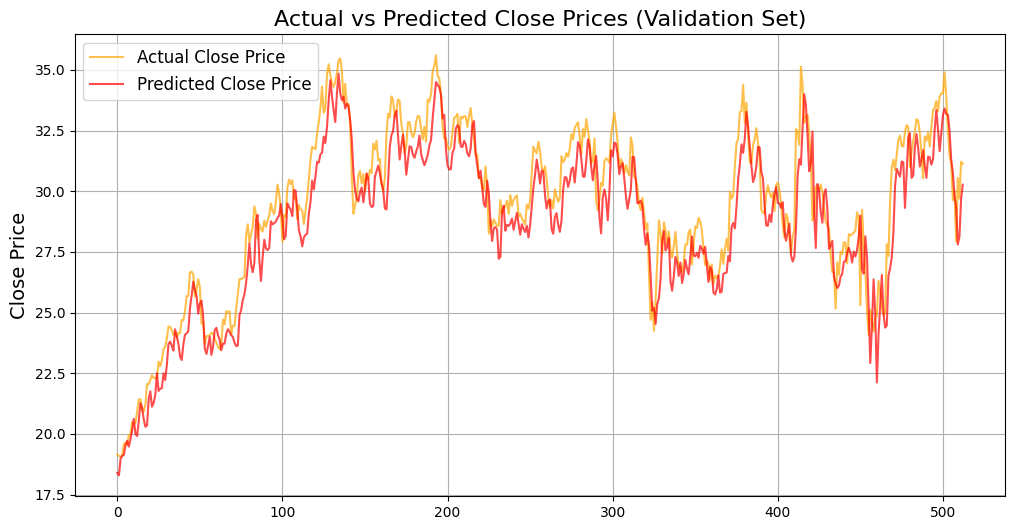

In [681]:
# Predict
predictions = model.predict(X_val)
print(predictions[0])
# Denormalized predictions
denormalized_predictions = Data1D("Close", tsla_close).denormalize(predictions.flatten())
denormalized_actual = Data1D("Close", tsla_close).denormalize(Y_val)

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the denormalized predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(denormalized_actual, label="Actual Close Price", color='orange', alpha=0.7)
plt.plot(denormalized_predictions, label="Predicted Close Price", color='red', alpha=0.7)
plt.title("Actual vs Predicted Close Prices (Validation Set)", fontsize=16)
plt.ylabel("Close Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


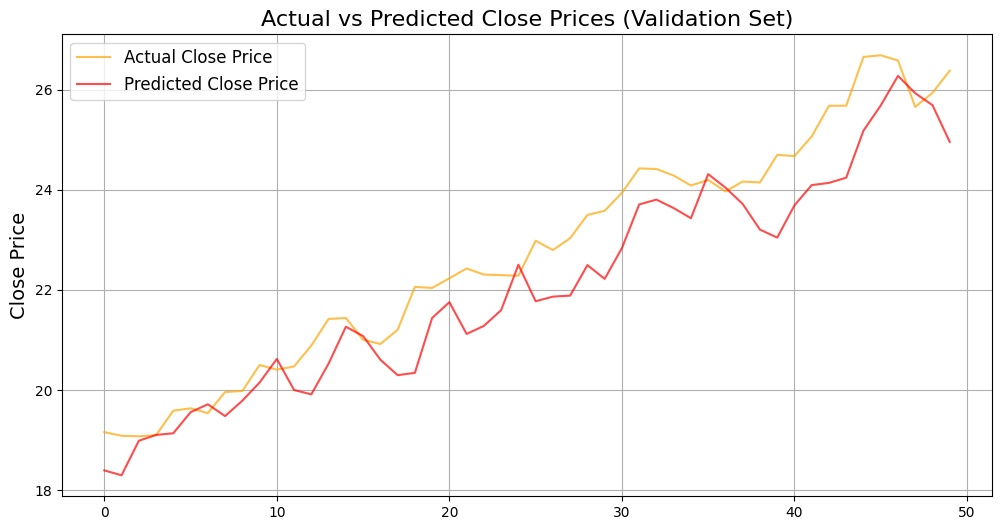

In [683]:
# Plot the denormalized predictions vs actual values for first 100 days
actual_price = denormalized_actual[:100]
predicted_price = denormalized_predictions[:100]

plt.figure(figsize=(12, 6))
plt.plot(actual_price[:50], label="Actual Close Price", color='orange', alpha=0.7)
plt.plot(predicted_price[:50], label="Predicted Close Price", color='red', alpha=0.7)
plt.title("Actual vs Predicted Close Prices (Validation Set)", fontsize=16)
plt.ylabel("Close Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## **Part 2 Conclusion**

I tried over 100 different transformer models in the section where I added gold data. 'Model: "functional_126"'. In each of these models, my goal was to predict the 'n+1'th value from 'n' sequential data points. The Transformer architecture performed poorly when I added gold data. In such datasets, the performance drops as we move further away from the training part. When I wanted it to perform well in the validation part, the model tended to copy the previous day's data. I concluded that the Transformer model requires a large amount of data. The data I have is not sufficient to train complex models. I produced many unsuccessful models. The reason I found these models unsuccessful was that they failed to converge enough towards the validation part. Keeping the model simple can lead to better performance with a limited amount of data. I think stock data is not the right place to test the functionality of the Transformer model. In such datasets, correlations can vary over time.